# Temporal Patterns

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/blob/main/docs/source/notebooks/temporal_patterns.ipynb)

In this tutorial, we will walk you through how to use General Additive Models (GAMs) to identify metabolic tasks following a trend across a trajectory defined by time points, pseudo-time, or ordered labels of cells.

Here, we will use the results we previously generated for the Human Endometrial Cell Atlas (HECA) dataset [(Mareckova & Garcia-Alonso et al 2023)](https://doi.org/10.1038/s41588-024-01873-w) by running our [Quick Start Tutorial](https://sccellfie.readthedocs.io/en/latest/notebooks/quick_start_human.html).

## This tutorial includes following steps:
* [Loading libraries](#loading-libraries)
* [Loading endometrium results](#loading-endometrium-results)
* [Defining cell trajectory](#defining-cell-trajectory)
* [Running GAM](#running-gam)
* [Filtering GAM results](#filtering-gam-results)
* [Visualization of results](#visualization-of-results)

## Loading libraries  <a class="anchor" id="loading-libraries"></a>

In [1]:
import sccellfie
import scanpy as sc

import pandas as pd
import numpy as np

## To avoid warnings
import warnings
warnings.filterwarnings("ignore")

In addition, we set up a folder to save our figures. This folder is stored in the settings of Scanpy:

In [2]:
sc.settings.figdir = './results/GAM-Figures/'

## Loading endometrium results <a class="anchor" id="loading-endometrium-results"></a>

We start opening the results previously generated and exported as shown in [this tutorial](https://sccellfie.readthedocs.io/en/latest/notebooks/quick_start_human.html#Save-single-cell-results).

In this case, we will load the objects that were present in ``results['adata']`` in that tutorial. This object contains:
- ``results['adata']``: contains gene expression in ``.X``.
- ``results['adata'].layers['gene_scores']``: contains gene scores as in the original CellFie paper.
- ``results['adata'].uns['Rxn-Max-Genes']``: contains determinant genes for each reaction per cell.
- ``results['adata'].reactions``: contains reaction scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.
- ``results['adata'].metabolic_tasks``: contains metabolic task scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.

Here, we will name this object directly as ``adata``. Each of the previous elements should be under ``adata.``, as for example ``adata.metabolic_tasks``.

In [3]:
adata = sccellfie.io.load_adata(folder='./results/',
                                filename='Human_HECA_scCellFie'
                               )

./results//Human_HECA_scCellFie.h5ad was correctly loaded
./results//Human_HECA_scCellFie_reactions.h5ad was correctly loaded
./results//Human_HECA_scCellFie_metabolic_tasks.h5ad was correctly loaded


In this case, we are interested in the metabolic task scores, which can be found in the ``adata.metabolic_tasks`` AnnData object.

In [4]:
adata.metabolic_tasks

AnnData object with n_obs × n_vars = 90001 × 215
    obs: 'n_genes', 'sample', 'percent_mito', 'n_counts', 'Endometriosis_stage', 'Endometriosis', 'Hormonal treatment', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Age', 'lineage', 'celltype', 'label_long'
    uns: 'Binary Stage_colors', 'Biopsy_type_colors', 'Endometrial_pathology_colors', 'Endometriosis_stage_colors', 'GarciaAlonso_celltype_colors', 'Group_colors', 'Hormonal treatment_colors', 'Library_genotype_colors', 'Mareckova_celltype_colors', 'Mareckova_epi_celltype_colors', 'Mareckova_lineage_colors', 'Processing_colors', 'Symbol_colors', 'Tan_cellsubtypes_colors', 'Tan_celltype_colors', 'Treatment_colors', 'celltype_colors', 'dataset_colors', 'genotype_colors', 'hvg', 'label_long_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'lineage_colors', 'neighbors', 'normalization', 'phase_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

## Defining cell trajectory <a class="anchor" id="defining-cell-trajectory"></a>

We can model the behavior of metabolic tasks across a trajectory of cells using GAMs. This trajectory can be defined by time points, pseudo-time, or pre-defined by ordered labels.

To illustrate its application, we will focus on glandular epithelial cells in the endometrium, that differentiate across distinct phases of the menstrual cycle as shown in the figure below. In this figure, we observed the layers of the endometrium, the main glandular cell types and the trajectory they follow across the menstrual phases.

![Figure 1.](https://raw.githubusercontent.com/earmingol/scCellFie/refs/heads/main/docs/source/_static/downstream/cell_trajectory.png){ width=50% }

Thus, we can define our trajectory based on this prior knowledge from the endometrial biology.

In [5]:
trajectory = ['SOX9_basalis', 'SOX9_functionalis_I', 'SOX9_functionalis_II', 'preGlandular', 'Glandular', 'Glandular_secretory']

Next, we need to make sure that we use cells labeled with these cell types, but also that they are present in the proper menstrual phases. Additionally, we only consider cells from Control samples.

In [6]:
def filter_donors(adata, only_control = True):
    df = adata.obs
    # First, include only cells in the menstrual phase where they are expected to be
    cond_filter = (df.Stage.isin(['Proliferative', 'Proliferative Disordered', 'Proliferative Late']) & \
                   df.celltype.isin(['SOX9_functionalis_I', 'SOX9_functionalis_II']) 
                  ) | \
                  (df.Stage.isin(['Secretory Early', 'Secretory Early-Mid', 'Secretory Mid', 'Secretory Late',]) & \
                   df.celltype.isin(['preGlandular', 'Glandular', 'Glandular_secretory',]) 
                  ) | \
                  (df.Stage.isin(['Proliferative', 'Proliferative Disordered', 'Proliferative Late', 
                                  'Secretory Early', 'Secretory Early-Mid', 'Secretory Mid', 'Secretory Late',]) & \
                   df.celltype.isin(['SOX9_basalis', ]) 
                  )
    # Then, include cells that are only in Control Samples
    if only_control:
        cond_filter = cond_filter & (df.Endometriosis == 'Control')
    return adata[cond_filter]

We create the ``mt_adata`` variable to represent the ``adata.metabolic_tasks`` object after filtering the cells

In [7]:
mt_adata = filter_donors(adata.metabolic_tasks)
mt_adata.shape

(7974, 215)

## Running GAM <a class="anchor" id="running-gam"></a>

GAMs extend linear models by allowing non-linear relationships between predictors and the response variable, while maintaining interpretability.

A GAM models the expected value of a response variable $y$ as the sum of smooth functions of predictors:

$$
y = \beta_0 + f_1(x_1) + f_2(x_2) + \cdots + f_p(x_p)
$$

Where:
- $y$ is the response variable (in our case, **the inferred activity of a metabolic task**),
- $\beta_0$ is the intercept,
- $f_j(x_j)$ are smooth functions (often splines) applied to the predictors.

In this analysis, we fit a GAM of the form:

$$
y_i = \beta_0 + f(x_i) + \varepsilon_i
$$

- $y_i$: inferred metabolic task activity in cell $i$,
- $x_i$: an ordered index representing pseudotime, spatial progression, or a predefined trajectory of cell types,
- $f(x)$: a smooth function capturing non-linear trends in metabolic activity along the trajectory,
- $\varepsilon_i$: residual noise.

We use the **[pyGAM](https://pygam.readthedocs.io/)** library to fit this model with **penalized splines**, which help control overfitting by penalizing excessive wiggliness in the function $f(x)$.

By fitting GAMs in this way, we can visualize and statistically assess whether a metabolic task shows structured variation across cell states, such as upregulation in specific cell types or gradual trends across a biological process (e.g. menstrual cycle).

In [8]:
gam_results = sccellfie.stats.fit_gam_model(
    mt_adata,
    cell_type_key='celltype',
    cell_type_order=trajectory,
)

Fitting GAMs for each var in adata: 100%|██████████| 215/215 [00:25<00:00,  8.50it/s]


Typically scCellFie runs GAMs on single cells. Additionally, it allows running
GAMs on pseudo-bulks, by passing the following parameters:

- ``use_pseudobulk=True`` : enables the use of pseudo-bulks instead of single cells.
- ``pseudobulk_agg='trimean'`` : specifies the aggregation method to summarize single cells into pseudo-bulks.
- ``n_pseudobulks=10`` : number of pseudo-bulks.
- ``cells_per_bulk=100`` : number of single cells included in each pseudo-bulk.

Pseudo-bulks will be built on the ``cell_type_key``.


<div class="alert alert-info">
<b>Note!</b>

If you are planning to use continuous values as cell labels (e.g. pseudo time), leave ``cell_type_order=None`` and specify the column where pseudo time values are located by using the parameter ``continuous_key``; for example, ``continuous_key=='pseudotime'``.

</div>

## Filtering GAM results <a class="anchor" id="filtering-gam-results"></a>

After fitting our GAMs, we can simplify their outputs into a dataframe containing metabolic tasks (rows) and specific information from the models, contained in the columns.

In [9]:
results_df = sccellfie.stats.analyze_gam_results(gam_results, fdr_level=0.01)

In [10]:
results_df.head(5)

,n_samples,edof,scale,AIC,loglikelihood,deviance,p_value,explained_deviance,mcfadden_r2,mcfadden_r2_adj,gene,significant,adj_p_value,significant_fdr
Glycine degradation,7974.0,5.845167,0.029838,225703.731784,-112845.020725,7968.154833,1.110223e-16,0.708444,0.258058,0.741929,Glycine degradation,True,1.147586e-16,True
Serine degradation,7974.0,5.845167,0.024380,282270.796524,-141128.553095,7968.154833,1.110223e-16,0.703896,0.266481,0.733508,Serine degradation,True,1.147586e-16,True
IMP salvage from hypoxanthine,7974.0,5.845167,0.328057,21182.718189,-10584.513927,7968.154833,1.110223e-16,0.687279,0.283959,0.715884,IMP salvage from hypoxanthine,True,1.147586e-16,True
GMP salvage from guanine,7974.0,5.845167,0.328057,21182.718189,-10584.513927,7968.154833,1.110223e-16,0.687279,0.283959,0.715884,GMP salvage from guanine,True,1.147586e-16,True
Methionine degradation,7974.0,5.845167,0.045556,140316.366871,-70151.338268,7968.154833,1.110223e-16,0.674027,0.279506,0.720470,Methionine degradation,True,1.147586e-16,True


With this dataframe, we can start selecting significant results:

In [11]:
results_df = results_df.loc[results_df.significant_fdr]

### Adjusted McFadden pseudo R2

In our dataframe, we can find the ``'mcfadden_r2_adj'`` column, which corresponds to the **adjusted McFadden pseudo R²**. This is a measure of model fit based on the log-likelihood of the fitted model relative to a null model (a model with no predictors). It is particularly useful for models with non-normal errors, such as logistic regression or generalized additive models (GAMs).

- **Formula**:

$$
R^2_{\text{McFadden}} = 1 - \frac{\text{log-likelihood of the fitted model}}{\text{log-likelihood of the null model}}
$$

- **Interpretation**:
  - A value close to **0** means the model performs no better than the null model.
  - A value close to **1** indicates a strong model fit.
  - **Adjusted McFadden R²** accounts for model complexity, preventing overfitting:

$$
R^2_{\text{McFadden, adj}} = 1 - \frac{\text{log-likelihood of the fitted model}}{\text{log-likelihood of the null model}} \times \frac{n - 1}{n - p - 1}
$$

Where:
  - \(n\) is the number of samples.
  - \(p\) is the number of predictors.

We can inspect the distribution of this coefficient, across the GAMs used to model each metabolic task:

<Axes: >

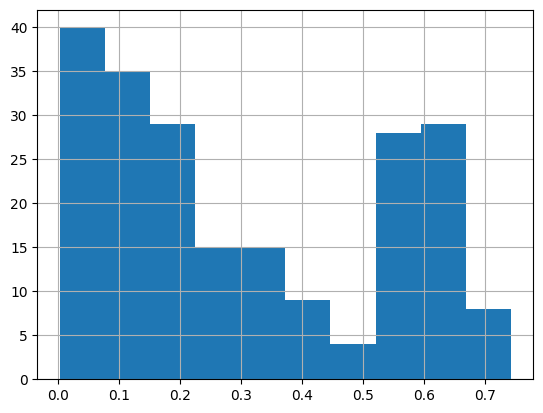

In [12]:
results_df['mcfadden_r2_adj'].hist()

### Scale measure

In our dataframe, we can find the ``'scale'`` column. The **scale** refers to the variance or the spread of the underlying distribution that is used for modeling. It indicates how much the observed data fluctuates around the fitted curve.

- **Interpretation**:
  - **Higher scale** values suggest that the data has more variability, implying a more spread-out distribution or greater fluctuations in the response variable.
  - **Lower scale** values indicate less variability and suggest a more concentrated or stable response around the fitted model.

- **Why use it?**: In GAMs, the scale can be informative about the nature of the data's distribution and helps in selecting which tasks or predictors might lead to clearer or more robust trends in the analysis. A higher scale may reflect data with more distinct or varied trends, while a lower scale may indicate more stable or predictable patterns.


We can inspect the distribution of this coefficient, across the GAMs used to model each metabolic task:

<Axes: >

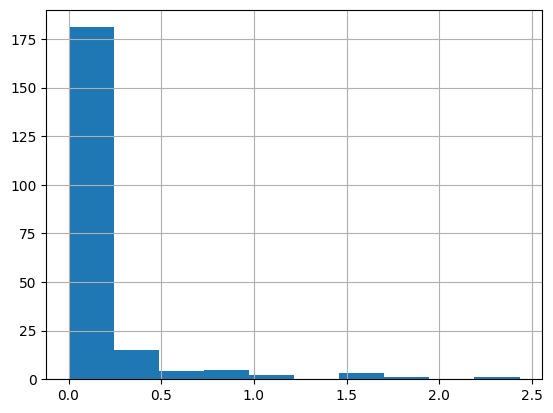

In [13]:
results_df['scale'].hist()

To identify metabolic tasks with meaningful dynamic behavior across the trajectory, we filtered for tasks that showed both good model fit and substantial variability. Specifically, we retained tasks with an adjusted McFadden pseudo R² > 0.2 and a scale parameter > 0.2.

- A value above 0.2 for the adjusted McFadden pseudo R² indicates a relatively strong fit, suggesting the model captures a genuine signal rather than noise (*McFadden wrote [on page 35 of this book chapter](https://elischolar.library.yale.edu/cowles-discussion-paper-series/707/) that **a value between 0.2 - 0.4 represents an excellent fit***).

- A higher scale value indicates more overall variability in the task's activity across the trajectory, which can help prioritize more dynamic or biologically variable patterns.

This dual threshold helps prioritize tasks with both high explanatory power and sufficient biological variability, reducing the chance of highlighting either overly flat or noisy trends.



<div class="alert alert-info">
<b>Note!</b>

For trajectories using continuous values (e.g. pseudo-time), instead of using the ``'mcfadden_r2_adj'``, we recommend using the ``'explained_deviance'`` to filter important metabolic tasks.

</div>

After filtering the metabolic tasks, we ended up with 15 important tasks.

In [14]:
gam_tasks = results_df.loc[(results_df['mcfadden_r2_adj'] > 0.2) & (results_df['scale'] > 0.2)].sort_values(by='scale', ascending=False)['gene'].values.tolist()
len(gam_tasks)

15

## Visualization of results <a class="anchor" id="visualization-of-results"></a>

We can visualize the trends of these tasks through different approaches.

### Violin plots

For example, we can use violin plots to see how their distributions across single cells are changing across the trajectory. Violin plots in this case are useful for categorical labels (ordered cell types in this case).

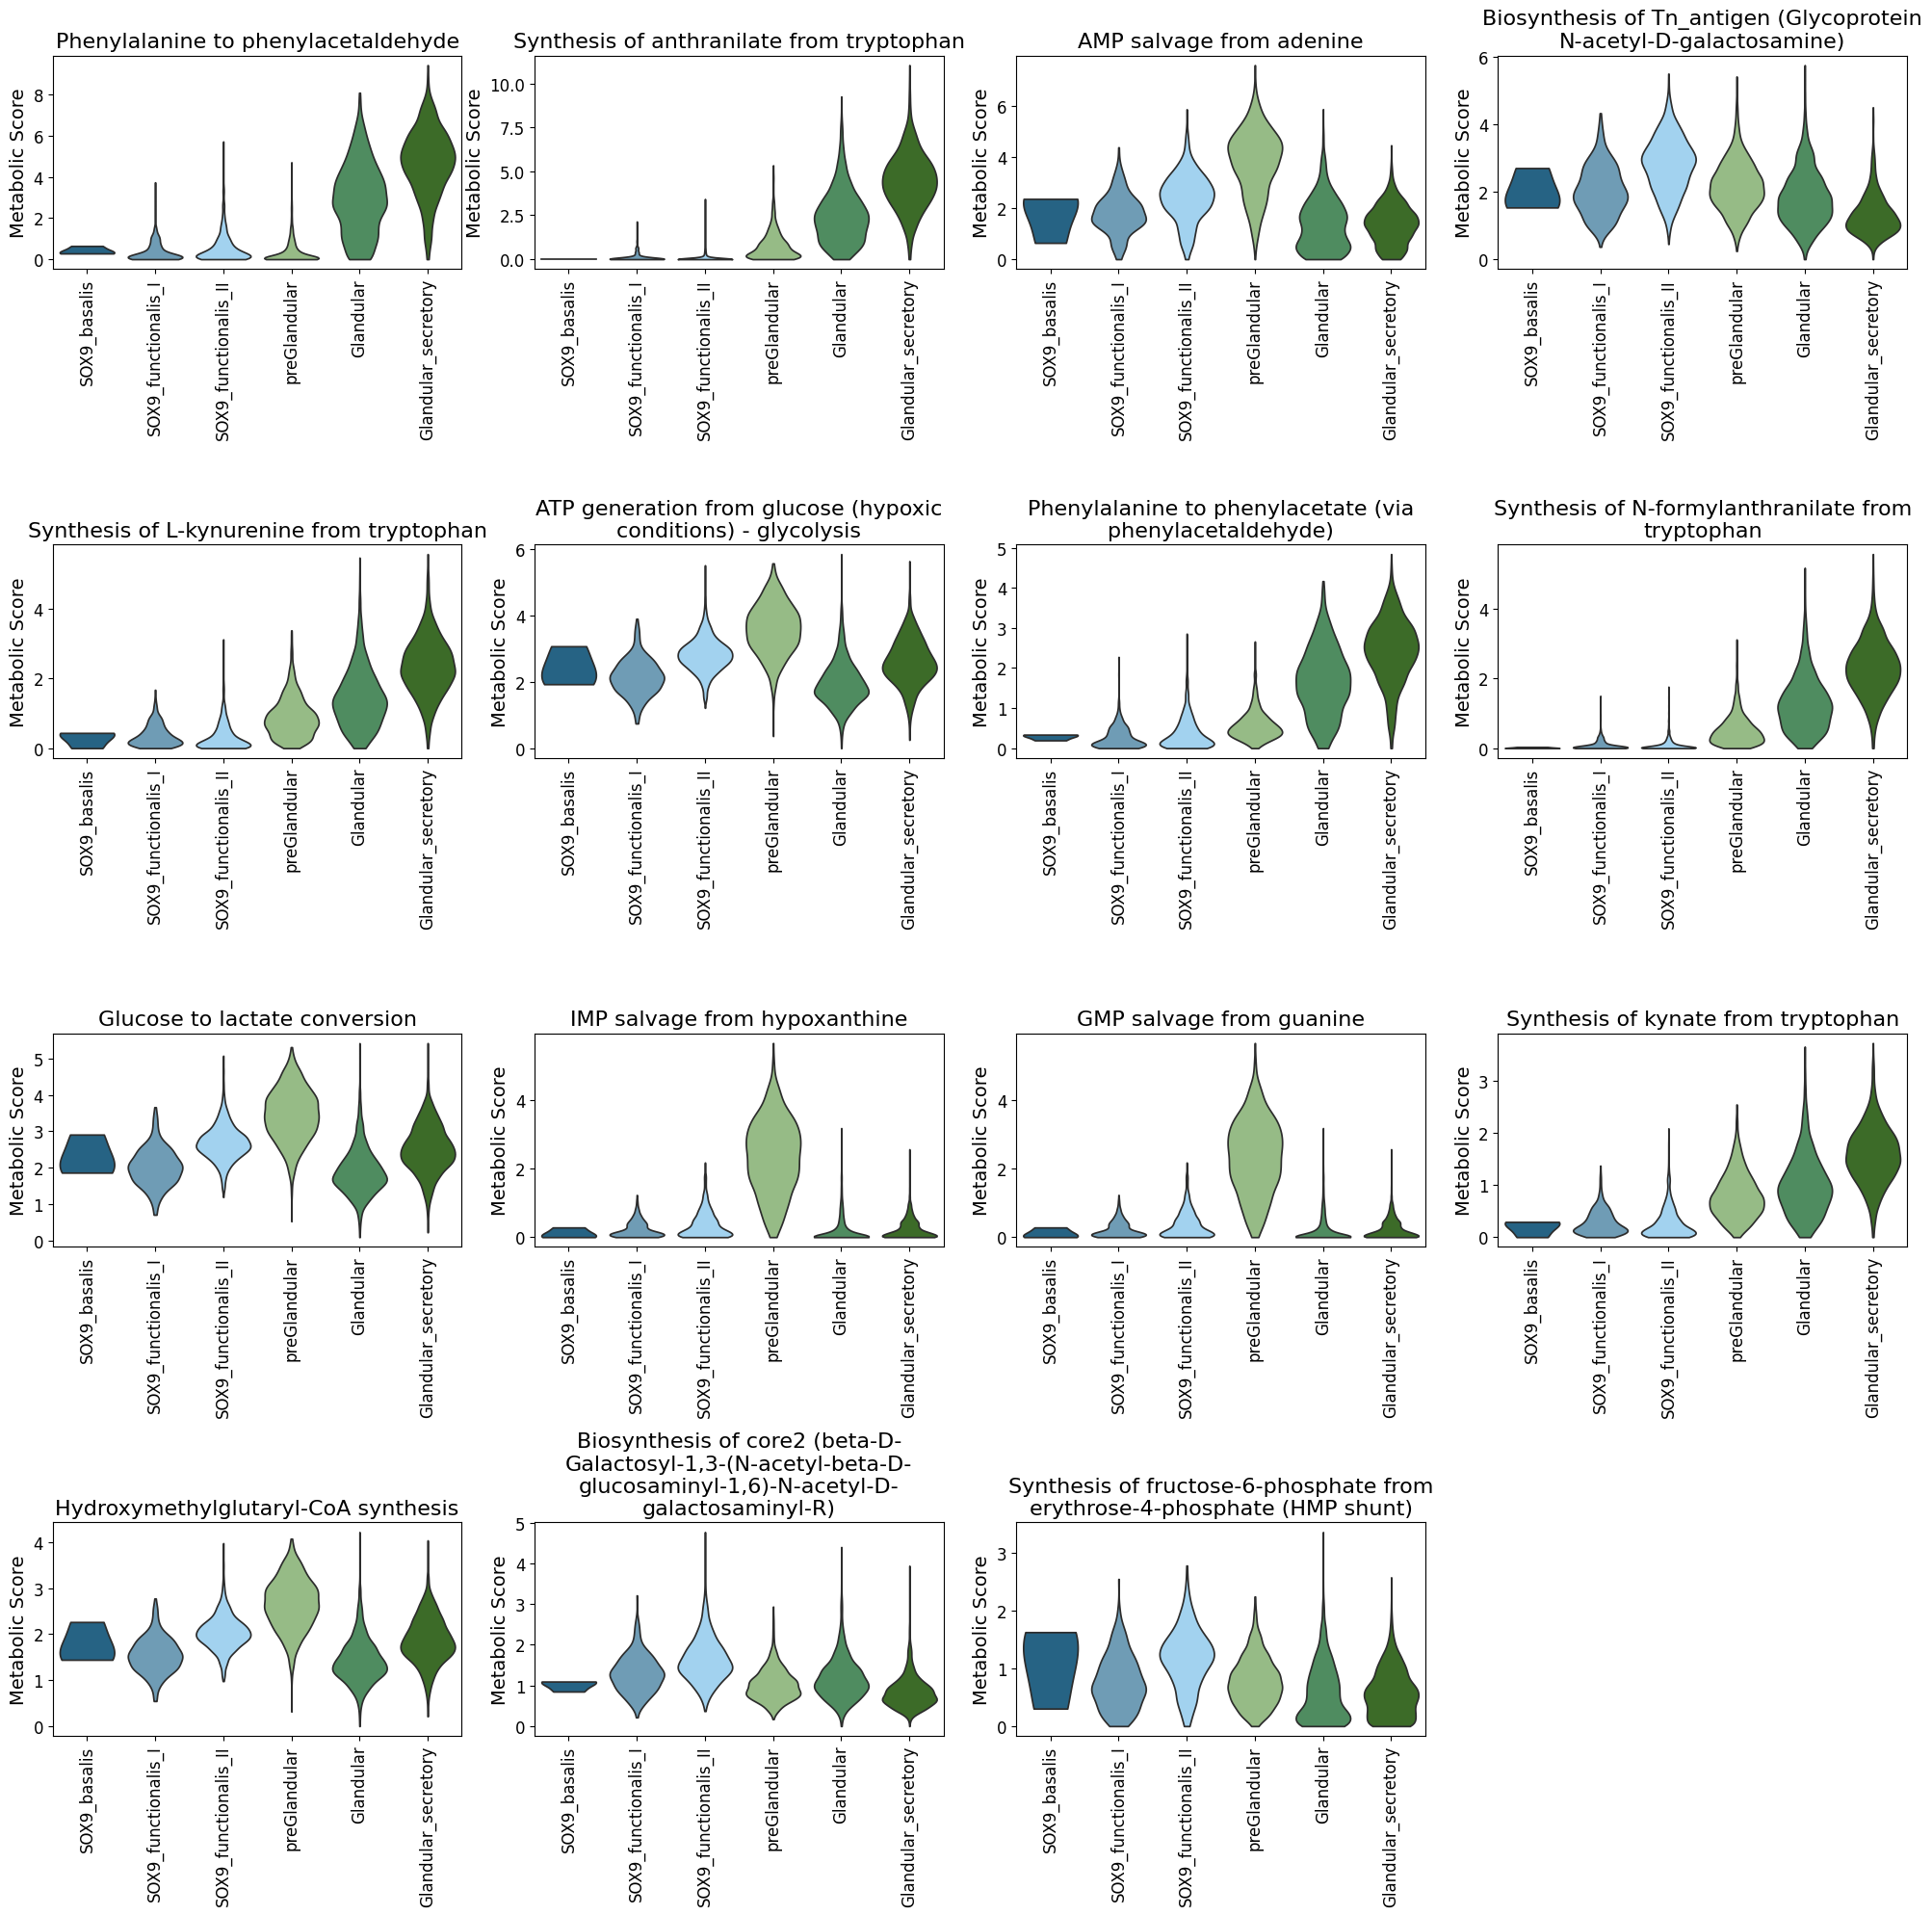

In [15]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(mt_adata,
                                                         features=gam_tasks,
                                                         groupby='celltype',
                                                         n_cols=4,
                                                         order=trajectory,
                                                         stripplot=False,
                                                         fontsize=12,
                                                         wrapped_title_length=45,
                                                         w_pad=None,
                                                         ylabel='Metabolic Score',
                                                         save='GAM-Violin-Control.pdf',
                                                         )

### Heatmap

We can also visualize an aggregated value for each ordered cell-type label. In this case we aggregate the single cells into cell types by using the Tuckey's trimean.

In [16]:
agg = sccellfie.expression.agg_expression_cells(adata=mt_adata,
                                                groupby='celltype',
                                                agg_func='trimean',
                                                gene_symbols=gam_tasks
                                               )

We order the cell types as defined in the trajectory:

In [17]:
agg = agg.loc[trajectory, :]

and perform a min-max normalization per metabolic task (min value across cell types will be 0, while max value will be 1)

In [18]:
df_plot = sccellfie.preprocessing.min_max_normalization(agg.T, axis=1)

**Marsilea**

Then, we can use **seaborn** or any plotting library to visualize this information as a heatmap. Here, we use **marsilea**, which allows us to visualize additional information.

To install it, run:
``pip install marsilea``

You can rea more on its [library documentation](https://marsilea.readthedocs.io/)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import marsilea.plotter as mp
import marsilea as ma

**Data preparation for marsilea**

We first generate the annotation of each cell type to indicate in which menstrual cycle they are present:

In [20]:
cell_groups = {'Basal' : ['SOX9_basalis'],
               'Proliferative / Folicular' : ['SOX9_functionalis_I', 'SOX9_functionalis_II'],
               'Secretory / Luteal' : ['preGlandular', 'Glandular', 'Glandular_secretory']
              }

cell_groups = {cell : phase for phase, cells in cell_groups.items() for cell in cells}

Then, we annotate each metabolic task by their major groups. We can find this information in the scCellFie's metabolic database:

In [21]:
sccellfie_db = sccellfie.datasets.database.load_sccellfie_database(organism='human')

We generate a dictionary mapping this information into each task. Additionally we rename some of them to keep specific capital letters (e.g. ER and Golgi).

In [22]:
task_dict = sccellfie_db['task_info'].set_index('Task')['System'].to_dict()
task_dict = {k : v.capitalize() for k, v in task_dict.items()}
for k, v in task_dict.items():
    if v == 'Processing in the er':
        task_dict[k] = 'Processing in the ER'
    elif v == 'Processing in the golgi':
        task_dict[k] = 'Processing in the Golgi'

These are the inputs, including data and some annotations for the plot

In [23]:
data = df_plot.values
cell_labels = np.asarray(list(df_plot.columns))
task_labels = np.asarray(list(df_plot.index))
cell_cat = np.asarray([cell_groups[cell] for cell in df_plot.columns])
task_cat = np.asarray([task_dict[task] for task in df_plot.index])

We generate a color palette for the metabolic task annotations:

In [24]:
total_task_cat = sorted(set(task_dict.values()))
task_palette = glasbey.extend_palette('tab10', palette_size=len(total_task_cat))
task_colors = {t : task_palette[i] for i, t in enumerate(total_task_cat)}
cell_palette = ['#FFABA4', '#D8A3B7', '#EDAF5C']

And specify the size of the legend

In [25]:
plt.rc('legend',fontsize=28, title_fontsize=32)

Finally generate the plot:

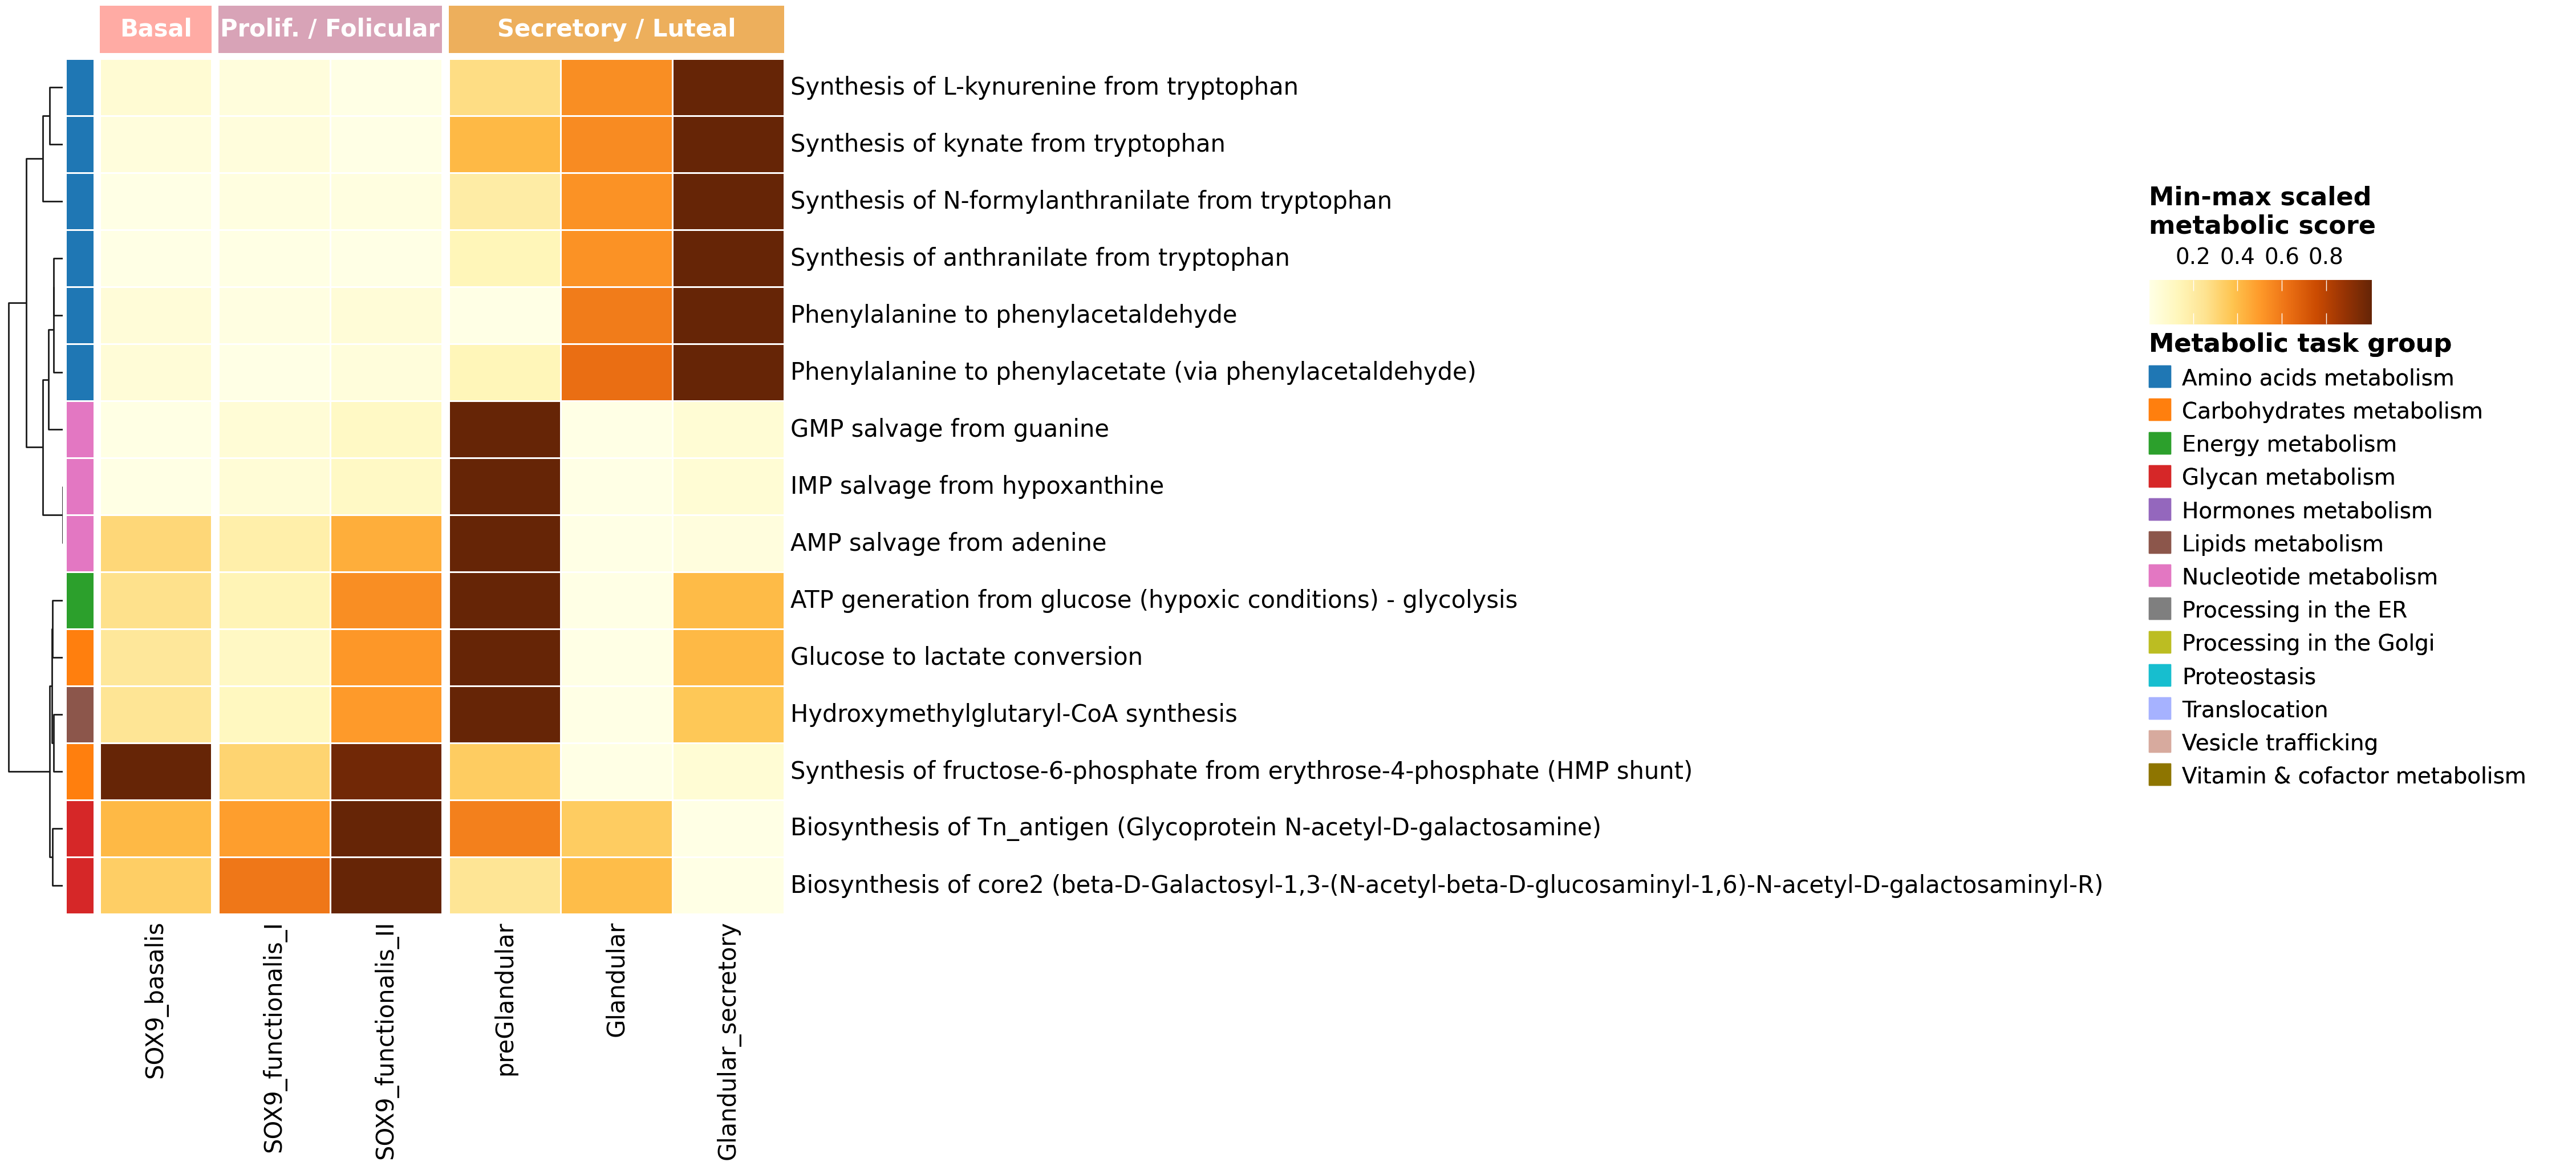

In [26]:
vlimit = np.max(np.abs(data))
linewidth = 2.

h = ma.Heatmap(data, 
               linewidth=linewidth,
               vmin=0, vmax=1,
               height=1*len(gam_tasks), # height depends on the number of tasks
               width=2*len(trajectory), # width depends on the number of ordered cell types
               cmap='YlOrBr',
               cbar_kws={'title' : 'Min-max scaled\nmetabolic score', 'orientation' : 'horizontal'}, 
              )

h.group_cols(cell_cat, order=['Basal', 'Proliferative / Folicular', 'Secretory / Luteal'], spacing=0.01)
h.add_top(mp.Chunk(['Basal', 'Prolif. / Folicular', 'Secretory / Luteal'], cell_palette, padding=30, fontsize=30, fontweight='bold', c='white'), pad=0.1)
h.add_left(mp.Colors(task_cat, palette=task_colors, label='', legend_kws={'title' : 'Metabolic task group'}, linewidth=linewidth, linecolor='white'), size=.5, pad=.1)
h.add_bottom(mp.Labels(cell_labels, fontsize=30, rotation=90, rotation_mode='anchor', ha='right', va='center'), pad=.1)
h.add_right(mp.Labels(task_labels, fontsize=30, rotation=0, rotation_mode='anchor', ha='left', va='center'), pad=.1)
h.add_dendrogram("left", method='ward', metric='euclidean', size=1, linewidth=2., add_base=True, pad=0.05)
h.add_legends(stack_size=3, stack_by='col', align_legends='left')
h.render()

# To save the figure, uncomment the following line
# h.save(f'{sc.settings.figdir}/Heatmap.pdf', dpi=300)